# Demo 3: Denoising CNN Autoencoder

* Using PyTorch
* Expected time: 5 minutes

In this demo, we will look at very simple autoencoder architectures and showcase their expressive power for tasks like denoising.

## Imports

As with other notebooks, I figure out imports as I go. I've refactored all the imports in this one cell for convenience.

In [463]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import glob
import imageio
import cv2
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from tqdm import tqdm
from typing import List, Tuple

In [265]:
# You *don't* have to understand everything happening here,
# but we will instantiate this class next, and it will make things a bit more clear.

class MultiLayerPerceptron(nn.Module):

    def __init__(
        self, 
        input_dim: int, 
        output_dim: int, 
        hidden_dims: List[int], 
        activation: nn.Module,
        final_layer_activation: nn.Module
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.activation: nn.Module = activation
        self.final_layer_activation = final_layer_activation
        self.fcs: nn.ModuleList = nn.ModuleList()
        layer_dims: np.ndarray = np.array([input_dim, *hidden_dims, output_dim])
        for dim1, dim2 in zip(layer_dims, layer_dims[1:]):
            fc = nn.Linear(dim1, dim2)
            self.fcs.append(fc)
        self.freeze_base_layers_yes = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for fc in self.fcs[:-1]:
            x = fc(x)
            x = self.activation.forward(x)

        x = self.fcs[-1](x)
        x = self.final_layer_activation(x)
        return x
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        x = torch.as_tensor(x).cuda()
        preds = self.forward(x)
        return preds.cpu().detach().numpy()

## Here's What We're Going to Do

* Input: images with random noises added
* Target: actual images before random noises were added
* Prediction: images without noises according to what the NN has learned

Let's do something silly: we will cook up only one fake image, and try adding noises somehow. For demo's sake, we won't worry about generalization but the expressivity that neural networks afford.

In [266]:
synthesized_image = np.ones([28, 28]) * 128

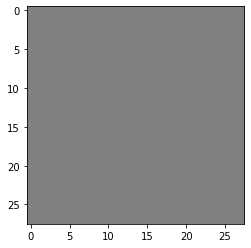

In [267]:
plt.figure()
plt.imshow(synthesized_image, cmap="gray", vmin=0, vmax=255)
plt.show()

As with before, representation matters. We'll flatten this image into a 784-dimensional vector.

In [268]:
synthesized_image_flattened = synthesized_image.reshape(-1)
print(synthesized_image_flattened.shape)

(784,)


Now, we will corrupt this image by adding a noise to each pixel at random.

In [269]:
synthesized_image_noised = synthesized_image_flattened + np.random.normal(0, 4, synthesized_image_flattened.shape)

What does the corrupted image look like?

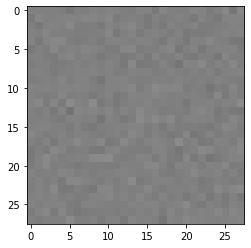

In [270]:
plt.figure()
plt.imshow(synthesized_image_noised.reshape(28, 28), cmap="gray", vmin=0, vmax=255)
plt.show()

Q: Where do we see these kinds of "corruptions" in real life?

Now, convince yourselves that `synthesized_image_flattened` is your target, and `synthesized_image_noised` is your input. In other words, we want to "predict" the un-noised version from the noised version of the image.

## Pop Quiz

Q: What are the two main components of an autoencoder?

In [271]:
encoder = MultiLayerPerceptron(
    input_dim=784,
    output_dim=10,
    hidden_dims=[256, 256],
    activation=nn.ReLU(),
    final_layer_activation=nn.ReLU()
)

In [272]:
synthesized_image_noised_tensor = torch.tensor(synthesized_image_noised).float()
embedding_tensor = encoder.forward(synthesized_image_noised_tensor)
print(embedding_tensor.shape)

torch.Size([10])


Q: What is `embedding_tensor`?

* A. the smaller version of the noisy image
* B. some garbage 10-dimensional vector
* C. none of the above

In [273]:
print(embedding_tensor)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 19.3438, 10.5689,
         5.0561,  1.1380], grad_fn=<ReluBackward0>)


Q: Do you notice any pattern in the numbers inside `embedding_tensor`? What would be the reason for this?

In [274]:
decoder = MultiLayerPerceptron(
    input_dim=10,
    output_dim=784,
    hidden_dims=[256, 256],
    activation=nn.ReLU(),
    final_layer_activation=nn.Identity()
)

In [275]:
predicted_image_flattened_tensor = decoder.forward(embedding_tensor)

In [276]:
print(predicted_image_flattened_tensor.shape)

torch.Size([784])


What does the prediction look like?

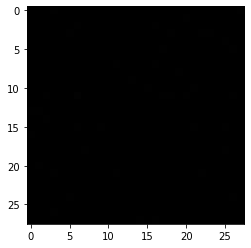

In [277]:
plt.figure()
plt.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(28, 28), cmap="gray", vmin=0, vmax=255)
plt.show()

Not so good! Of course, it's because the NN hasn't learned anything yet. Let's set up a quick training loop:

In [278]:
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(lr=3e-4, params=list(encoder.parameters()) + list(decoder.parameters()))

In [279]:
for _ in tqdm(range(1000)):
    # get data (i.e. input and target)
    synthesized_image = np.ones([28, 28]) * 128
    synthesized_image_flattened = synthesized_image.reshape(-1)
    synthesized_image_flattened_tensor = torch.tensor(synthesized_image_flattened).float()
    synthesized_image_noised = synthesized_image_flattened + np.random.normal(0, 4, synthesized_image_flattened.shape)
    synthesized_image_noised_tensor = torch.tensor(synthesized_image_noised).float()

    embedding_tensor = encoder.forward(synthesized_image_noised_tensor)
    predicted_image_flattened_tensor = decoder.forward(embedding_tensor)
    
    loss = mse_loss.forward(predicted_image_flattened_tensor, synthesized_image_flattened_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.46it/s]


In [280]:
synthesized_image = np.ones([28, 28]) * 128
synthesized_image[13, 13] = 255.
synthesized_image_flattened = synthesized_image.reshape(-1)
synthesized_image_flattened_tensor = torch.tensor(synthesized_image_flattened).float()
synthesized_image_noised = synthesized_image_flattened + np.random.normal(0, 4, synthesized_image_flattened.shape)
synthesized_image_noised_tensor = torch.tensor(synthesized_image_noised).float()

In [281]:
embedding_tensor = encoder.forward(synthesized_image_noised_tensor)
predicted_image_flattened_tensor = decoder.forward(embedding_tensor)

Let's see how well our NN gets rid of the noise!

<Figure size 432x288 with 0 Axes>

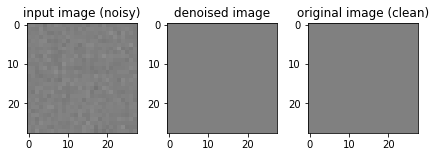

In [282]:
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(synthesized_image_noised.reshape(28,28), cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(28, 28), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(synthesized_image, cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

Hey, not bad! But... what happens if I have a different image with the same noise?

In [283]:
dataset = MNIST("mnist", download=True)

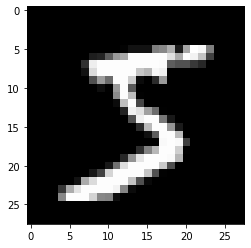

In [284]:
image = np.array(dataset[0][0])
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.show()

<Figure size 432x288 with 0 Axes>

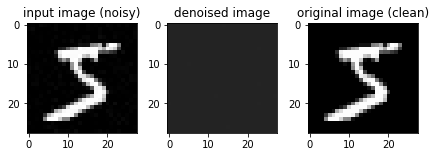

In [285]:
image_flattened = image.reshape(-1)
image_flattened_tensor = torch.tensor(image_flattened).float()
image_noised = image_flattened + np.random.normal(0, 4, image_flattened.shape)
image_noised_tensor = torch.tensor(image_noised).float()

embedding_tensor = encoder.forward(image_noised_tensor)
predicted_image_flattened_tensor = decoder.forward(embedding_tensor)

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image_noised.reshape(28,28), cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(28, 28), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(image, cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

## Autoencoder for Denoising Drawings

In the wild, denoising would be super convenient for "cleaning up" sketches, like the examples we see here:

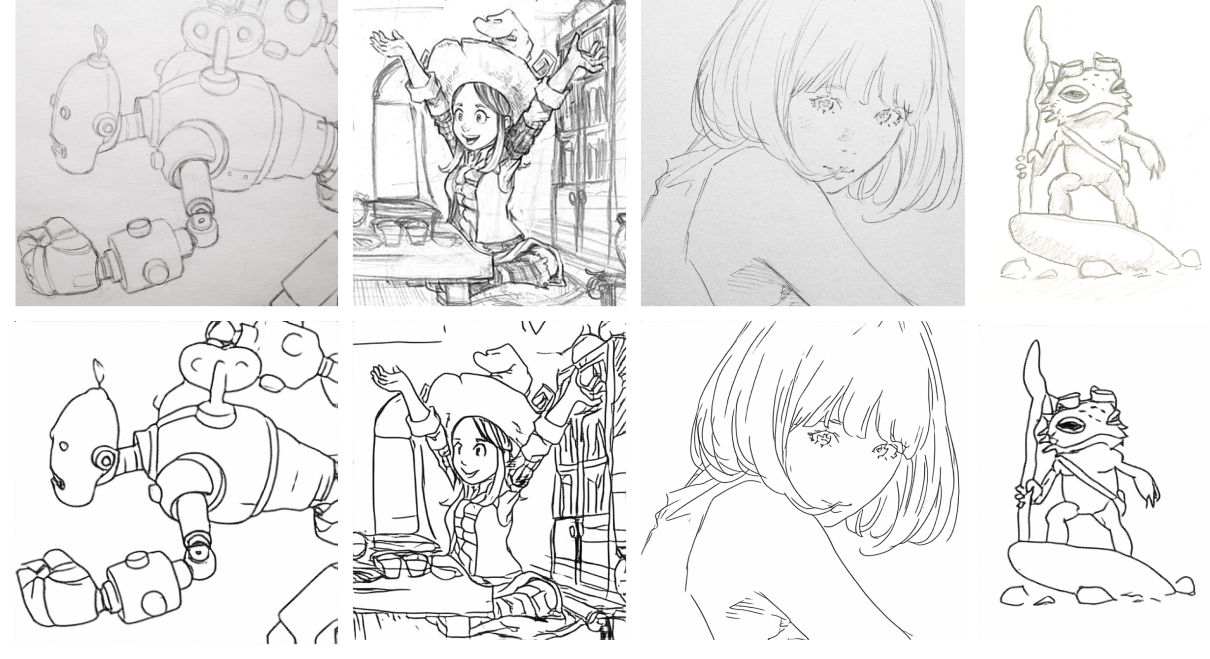

These images aren't publicly available due to copyright reasons, but we can mimick something like this, starting with a clean drawing.

In [1347]:
class SketchDataset:
    
    def __init__(self, path, n_examples):
        self.path = path
        self.filenames = glob.glob(f"{path}/png/**/*.png")
        np.random.shuffle(self.filenames)
        self.filenames = self.filenames[:n_examples]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        image_array = cv2.imread(self.filenames[index], cv2.IMREAD_GRAYSCALE)
        image_array_resized = cv2.resize(image_array, (256, 256))
        return image_array_resized
        
        
class NoisedSketchDataset(SketchDataset):
    
    def __getitem__(self, index):
        image_array = super().__getitem__(index)
        return image_array, np.clip(image_array + np.random.normal(0, 20, image_array.shape), 0, 255)
    

In [1348]:
dataset = NoisedSketchDataset("sketches_png/", 1)

In [1352]:
len(dataset)

1

In [1353]:
image_clean, image_noised = dataset[0]

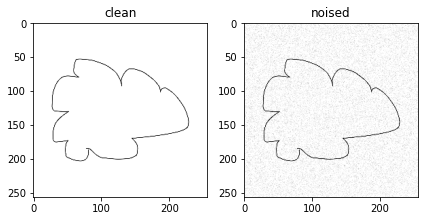

In [1354]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_clean, cmap="gray", vmin=0, vmax=255)
ax1.set_title("clean")
ax2.imshow(image_noised, cmap="gray", vmin=0, vmax=255)
ax2.set_title("noised")
plt.tight_layout()
plt.show()

Let's train our NN to denoise these drawings.

In [1355]:
encoder = MultiLayerPerceptron(
    input_dim=65536,
    output_dim=10,
    hidden_dims=[256, 256],
    activation=nn.ReLU(),
    final_layer_activation=nn.ReLU()
)
decoder = MultiLayerPerceptron(
    input_dim=10,
    output_dim=65536,
    hidden_dims=[256, 256],
    activation=nn.ReLU(),
    final_layer_activation=nn.Sigmoid()
)
optimizer = torch.optim.Adam(lr=3e-3, params=list(encoder.parameters()) + list(decoder.parameters()))

Note that `input_dim` is 256 * 256 = 65536. That's a pretty large number! Notice that I also increased the embedding size to 100, in case it's too small to be useful.

In [1356]:
data_loader = DataLoader(dataset, batch_size=1)

In [1357]:
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n_examples = images_clean.shape[0]
        images_clean_flattened = images_clean.reshape(n_examples, -1).float() / 255.
        images_noised_flattened = images_noised.reshape(n_examples, -1).float() / 255.

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_flattened = images_clean_flattened.cuda()
        images_noised_flattened = images_noised_flattened.cuda()

        embeddings_tensor = encoder.forward(images_noised_flattened)
        predicted_images_flattened_tensor = decoder.forward(embeddings_tensor)

        loss = mse_loss.forward(predicted_images_flattened_tensor, images_clean_flattened)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.47it/s]


<Figure size 432x288 with 0 Axes>

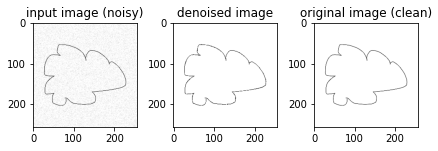

In [1358]:
image_clean, image_noised = dataset[0]
image_clean_flattened_tensor = torch.tensor(image_clean).reshape(-1).float() / 255.
image_noise_flattened_tensor = torch.tensor(image_noised).reshape(-1).float() / 255.

embedding_tensor = encoder.forward(image_noise_flattened_tensor)
predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image_noised.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(image_clean.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

In [1369]:
encoder = MultiLayerPerceptron(
    input_dim=65536,
    output_dim=10,
    hidden_dims=[256, 256],
    activation=nn.ReLU(),
    final_layer_activation=nn.ReLU()
)
decoder = MultiLayerPerceptron(
    input_dim=10,
    output_dim=65536,
    hidden_dims=[256, 256],
    activation=nn.ReLU(),
    final_layer_activation=nn.Sigmoid()
)
optimizer = torch.optim.Adam(lr=3e-3, params=list(encoder.parameters()) + list(decoder.parameters()))
dataset = NoisedSketchDataset("sketches_png/", 2)
data_loader = DataLoader(dataset, batch_size=1)
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n_examples = images_clean.shape[0]
        images_clean_flattened = images_clean.reshape(n_examples, -1).float() / 255.
        images_noised_flattened = images_noised.reshape(n_examples, -1).float() / 255.

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_flattened = images_clean_flattened.cuda()
        images_noised_flattened = images_noised_flattened.cuda()

        embeddings_tensor = encoder.forward(images_noised_flattened)
        predicted_images_flattened_tensor = decoder.forward(embeddings_tensor)

        loss = mse_loss.forward(predicted_images_flattened_tensor, images_clean_flattened)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.29it/s]


Nice... but what if there were more than one images?

<Figure size 432x288 with 0 Axes>

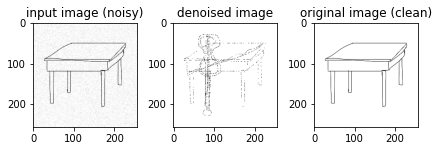

In [1372]:
image_clean, image_noised = dataset[0]
image_clean_flattened_tensor = torch.tensor(image_clean).reshape(-1).float() / 255.
image_noise_flattened_tensor = torch.tensor(image_noised).reshape(-1).float() / 255.

embedding_tensor = encoder.forward(image_noise_flattened_tensor)
predicted_image_flattened_tensor = decoder.forward(embedding_tensor) * 255.

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image_noised.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_flattened_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(image_clean.reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

Looks like the NN is just learning to blur everything, which actually helps minimize the loss, but not in the way we want. This tells me that a more expressive and smarter architecture is needed.

## CNN to the Rescue

To address the limitations of the fully-connected networks, we'll use a similar architecture as this one:

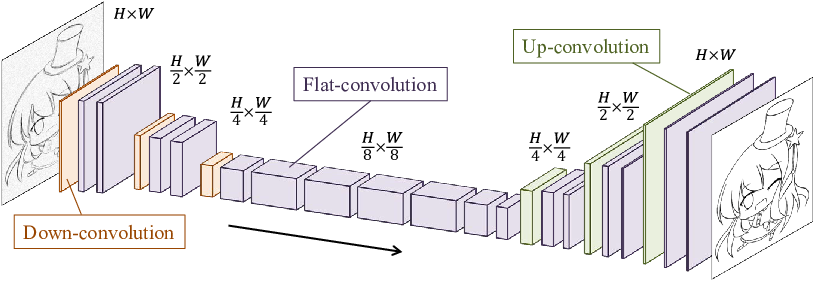

In [1373]:
class ConvolutionalNeuralNetwork(nn.Module):
    """
    Simplified implementation of CNN, assuming square grayscale image input,
    and average-pooling at each layer to reduce embedding size by half
    """

    def __init__(
            self,
            input_dim: Tuple[int],  # channel x height x width
            hidden_channels: Tuple[int],
            poolings: Tuple[nn.Module],
            output_dim: Tuple[int],  # channel x height x width
            activation_function: nn.Module,
            final_layer_activation: nn.Module,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_channels = hidden_channels
        self.poolings = poolings
        self.output_dim = output_dim
        self.activation_function = activation_function
        self.final_layer_activation = final_layer_activation

        all_channels = [self.input_dim[0], *hidden_channels, self.output_dim[0]]
        idxs = np.arange(len(all_channels))
        self.layers = nn.Sequential()
        for i, j in zip(idxs, idxs[1:-1]):  # "i" still iterates all hidden_channels etc.
            layer = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest') if poolings[i] == "up" else nn.Identity(),  # to implement half-stride for up-convolution
                nn.Conv2d(
                    in_channels=all_channels[i],
                    out_channels=all_channels[j],
                    kernel_size=(5, 5) if poolings[i] == "up" else (3, 3),
                    padding=2 if poolings[i] == "up" else 1,
                    stride=(2, 2) if poolings[i] == "down" else (1, 1)  # to implement down-convolution. (1, 1) with upsample is equivalent to half-stride
                ),
                nn.GroupNorm(1, all_channels[i], affine=False),
                self.activation_function,
            )
            self.layers.add_module(f"conv_block_{i}", layer)

        # final layer
        final_layer = nn.Sequential(
            nn.Conv2d(in_channels=all_channels[-2], out_channels=all_channels[-1], kernel_size=(3, 3), padding=1),
            self.final_layer_activation,
        )
        self.layers.add_module("final_layer", final_layer)

    def forward(self, x: torch.tensor):
        # to handle singular input
        if len(x.shape) == 2:
            x = x.reshape(1, 1, *x.shape)

        elif len(x.shape) == 3:
            x = x.reshape(1, *x.shape)

        # inflate the "in-channel" to allow Conv2D
        preds = self.layers.forward(x)
        return preds

In [1392]:
encoder = ConvolutionalNeuralNetwork(
    input_dim=(1, 256, 256),
    hidden_channels=(64, 64, 64, 128, 128, 128, 256, 256, 512),
    output_dim=(512, 32, 32),
    poolings=("down", "flat", "flat", "down", "flat", "flat", "down", "flat", "flat"),
    activation_function=nn.ReLU(),
    final_layer_activation=nn.ReLU()
)

decoder = ConvolutionalNeuralNetwork(
    input_dim=(512, 32, 32),
    hidden_channels=(256, 256, 256, 128, 128, 128, 64, 64, 64, 1),
    output_dim=(1, 256, 256),
    poolings=("up", "flat", "flat", "up", "flat", "flat", "up", "flat", "flat", "flat"),
    activation_function=nn.ReLU(),
    final_layer_activation=nn.Sigmoid()
)

optimizer = torch.optim.Adam(lr=3e-1, params=list(encoder.parameters()) + list(decoder.parameters()))

In [1393]:
image_noised_tensor = torch.tensor(image_noised).float()

In [1394]:
embeddings = encoder.forward(image_noised_tensor)

In [1395]:
embeddings.shape

torch.Size([1, 512, 32, 32])

In [1396]:
predicted_image_tensor = decoder.forward(embeddings)

In [1397]:
predicted_image_tensor.shape

torch.Size([1, 1, 256, 256])

In [1398]:
for _ in tqdm(range(1000)):
    for images_clean, images_noised in data_loader:
        n_examples = images_clean.shape[0]
        images_clean_tensor = images_clean.float() / 255.
        images_noised_tensor = images_noised.float() / 255.

        # for gpu acceleration
        encoder = encoder.cuda()
        decoder = decoder.cuda()
        images_clean_tensor = images_clean_tensor.cuda()
        images_noised_tensor = images_noised_tensor.cuda()
        
        n, h, w = images_noised_tensor.shape
        
        embeddings_tensor = encoder.forward(images_noised_tensor.reshape(n, 1, h, w))
        predicted_images_tensor = decoder.forward(embeddings_tensor)
        
        loss = mse_loss.forward(predicted_images_tensor, images_clean_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(loss.data)
    
# undo gpu acceleration
encoder = encoder.cpu()
decoder = decoder.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.55it/s]


tensor(0.0147, device='cuda:0')


<Figure size 432x288 with 0 Axes>

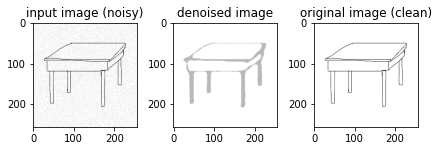

In [1401]:
image_clean, image_noised = dataset[0]
image_clean_tensor = torch.tensor(image_clean).float() / 255.
image_noise_tensor = torch.tensor(image_noised).float() / 255.

embedding_tensor = encoder.forward(image_noise_tensor)
predicted_image_tensor = decoder.forward(embedding_tensor) * 255.

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image_noised, cmap="gray", vmin=0, vmax=255)
ax1.set_title("input image (noisy)")
ax2.imshow(predicted_image_tensor.cpu().detach().numpy().reshape(256, 256), cmap="gray", vmin=0, vmax=255)
ax2.set_title("denoised image")
ax3.imshow(image_clean, cmap="gray", vmin=0, vmax=255)
ax3.set_title("original image (clean)")
plt.tight_layout()
plt.show()

Well, that's a start! Looks like there are issues with line tickness, but the NN is learning how to form edges without the noise.

# Notes:

* The proposed autoencoder architecture could be improved further by using more advanced techniques, e.g. introducing skip-connections or attention layers, and training for much longer (training for 12+ hours is normal!).
* Looking at the examples used for training actually gives you a very poor measure of the model's general performance, but for the sake of demo, we're not going to talk about the trickier side of machine learning.